In [1]:
# Importing libraries for interaction with AWS
import boto3
from botocore.exceptions import ClientError
# Importing library for request data from web
from requests import get
# Importing library for converting json data to csv data
import pandas as pd
# Importing library for visualizing data
import matplotlib.pyplot as plt
# Import other libraries
from pathlib import Path
import logging
import os

## Getting data from NBU API in json format

In [38]:
# Get request from NBU API
usd_url = "https://bank.gov.ua/NBU_Exchange/exchange_site?start=20210101&end=20211231&valcode=usd&sort=exchangedate&order=asc&json"
eur_url = "https://bank.gov.ua/NBU_Exchange/exchange_site?start=20210101&end=20211231&valcode=eur&sort=exchangedate&order=asc&json"

In [45]:
# Get json data from the request about US Dollar
r = get(usd_url)
usd_json_df = pd.read_json(r.text)

In [46]:
# Get json data from the request about Euro
r = get(eur_url)
eur_json_df = pd.read_json(r.text)

In [47]:
usd_json_df.head()

,exchangedate,r030,cc,txt,enname,rate,units,rate_per_unit,group,calcdate
0,01.01.2021,978,EUR,Євро,Euro,34.7396,1,34.7396,1,30.12.2020
1,02.01.2021,978,EUR,Євро,Euro,34.7396,1,34.7396,1,30.12.2020
2,03.01.2021,978,EUR,Євро,Euro,34.7396,1,34.7396,1,30.12.2020
3,04.01.2021,978,EUR,Євро,Euro,34.7396,1,34.7396,1,30.12.2020
4,05.01.2021,978,EUR,Євро,Euro,34.9389,1,34.9389,1,04.01.2021


In [49]:
# Drop unnecessary column
usd_json_df = usd_json_df.drop(columns=["r030", "cc", "txt", "group"])
eur_json_df = eur_json_df.drop(columns=["r030", "cc", "txt", "group"])

In [55]:
usd_json_df.head()

,date,currency,rate,units,rate_per_unit,calcdate
0,01.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
1,02.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
2,03.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
3,04.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
4,05.01.2021,US Dollar,28.4310,1,28.4310,04.01.2021


In [53]:
# Change name of some columns
usd_json_df = usd_json_df.rename(columns={"exchangedate": "date", "enname": "currency"})
eur_json_df = eur_json_df.rename(columns={"exchangedate": "date", "enname": "currency"})

In [54]:
usd_json_df.head()

,date,currency,rate,units,rate_per_unit,calcdate
0,01.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
1,02.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
2,03.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
3,04.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
4,05.01.2021,US Dollar,28.4310,1,28.4310,04.01.2021


## Convert json format to csv file with pandas

In [38]:
# Making Path for output csv files
output_path = Path("output/")
usd_path = Path(f"{output_path}/usd_currency.csv")
eur_path = Path(f"{output_path}/eur_currency.csv")

In [74]:
# Form directory if not exist
output_path.mkdir(exist_ok=True)

In [75]:
# Save USD data to csv file
usd_json_df.to_csv(usd_path)

In [76]:
# Save EUR data to csv file
eur_json_df.to_csv(eur_path)

## Prepare function for s3 bucket manipulation

In [3]:
def s3_file_actions(s3_client, bucket_name, action="upload", file_path=None, bucket_file_name=None):
    """
    Upload a file to on S3 bucket;
    :param s3_client: client for manipulating with S3 Bucket;
    :param bucket_name: Bucket to upload to;
    :param action: string for defining actions that be used for manipulating with file;
    :param file_path: local file path for manipulating;
    :param bucket_file_name: S3 bucket file name (if not specified then file_path name will be used);
    :return: True if action have success, else False.
    """
    match action:
        case "upload":
            # If s3 bucket file name was not specified, use file_name with 's3_' in begin of the file name
            if bucket_file_name is None:
                bucket_file_name = "s3_" + os.path.basename(file_path)

            # Upload the file
            try:
                s3_client.upload_file(file_path, bucket_name, bucket_file_name)
            except ClientError as e:
                logging.error(e)
                return False
            return True
        case "download":
            # If file_name was not specified, use file_name
            if file_path is None:
                file_path = "../output/" + os.path.basename(bucket_file_name)

            # Download the file
            try:
                s3_client.download_file(bucket_name, bucket_file_name, file_path)
            except ClientError as e:
                logging.error(e)
                return False
            return True

## Upload files to s3 bucket

In [2]:
# View existing buckets
s3 = boto3.client('s3')
response = s3.list_buckets()
# Output the bucket names
print("Existing buckets:")
for bucket in response["Buckets"]:
    print(f"\t{bucket['Name']}")

Existing buckets:
	lab2itbucket


In [9]:
# Define bucket name
s3_bucket = "lab2itbucket"

In [5]:
# Check existing files
!ls output/

eur_currency.csv  usd_currency.csv


In [40]:
# Upload files to S3 bucket
s3_file_actions(eur_path, s3_bucket, "upload", "s3_eur_currency.csv")
s3_file_actions(usd_path, s3_bucket, "upload", "s3_usd_currency.csv")

True

## Download files from s3 bucket

In [41]:
# Download file from S3 bucket
s3_file_actions("output/s3_eur_currency.csv", s3_bucket, "download", "s3_eur_currency.csv")
s3_file_actions("output/s3_usd_currency.csv", s3_bucket, "download",  "s3_usd_currency.csv")

True

In [13]:
# Check existing files
!ls output/

eur_currency.csv  s3_eur_currency.csv  s3_usd_currency.csv  usd_currency.csv


## Visualise exchange rate chart

In [42]:
# Take data from files
eur_df = pd.read_csv("output/s3_eur_currency.csv")
usd_df = pd.read_csv("output/s3_usd_currency.csv")

In [43]:
# Check eur_df
eur_df.head()

,Unnamed: 0,date,currency,rate,units,rate_per_unit,calcdate
0,0,01.01.2021,Euro,34.7396,1,34.7396,30.12.2020
1,1,02.01.2021,Euro,34.7396,1,34.7396,30.12.2020
2,2,03.01.2021,Euro,34.7396,1,34.7396,30.12.2020
3,3,04.01.2021,Euro,34.7396,1,34.7396,30.12.2020
4,4,05.01.2021,Euro,34.9389,1,34.9389,04.01.2021


In [35]:
# Check usd_df
usd_df.head()

,Unnamed: 0,date,currency,rate,units,rate_per_unit,calcdate
0,0,01.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
1,1,02.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
2,2,03.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
3,3,04.01.2021,US Dollar,28.2746,1,28.2746,30.12.2020
4,4,05.01.2021,US Dollar,28.4310,1,28.4310,04.01.2021


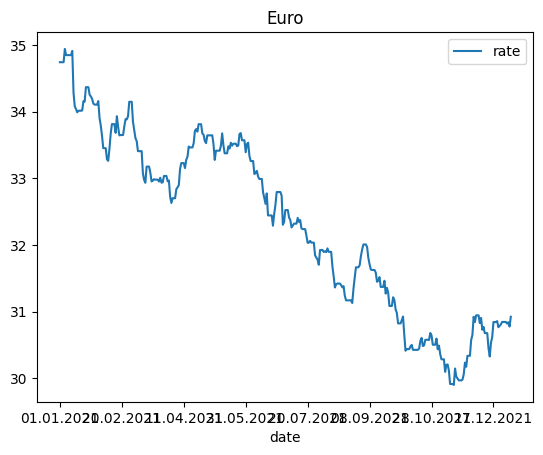

<Figure size 640x480 with 0 Axes>

In [48]:
# Create chart for Euro
eur_df.plot(x="date", y="rate", kind="line")
plt.title("Euro")
plt.show()
plt.savefig("output/eur_chart.png")

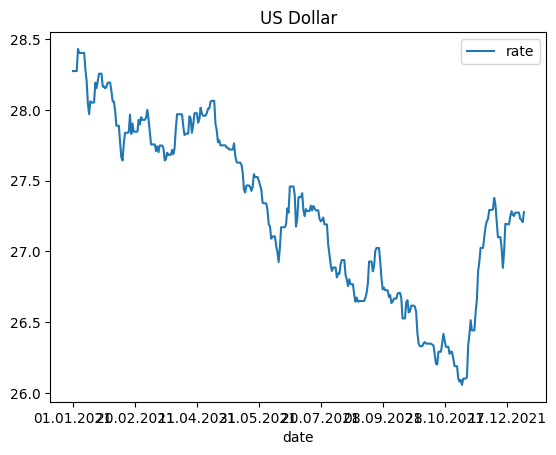

<Figure size 640x480 with 0 Axes>

In [49]:
# Create chart for US Dollar
usd_df.plot(x="date", y="rate", kind="line")
plt.title("US Dollar")
plt.show()
plt.savefig("output/usd_chart.png")

### Save chart to s3 bucket

In [50]:
# Upload Chart to s3 bucket
s3_file_actions("output/eur_chart.png", s3_bucket, "upload", "s3_eur_chart.png")
s3_file_actions("output/eur_chart.png", s3_bucket, "upload", "s3_usd_chart.png")

True